# This notebook will show the implementation of NLP upon text reviews in our database of Amazon reviews. 

## We will explain each step and their results.

We import some of the main libraries we will work with:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\andre\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now, let us upload the database and observe it:

In [2]:
amazon_reviews = pd.read_csv("Amazon Reviews 1.csv")
#amazon_reviews

C:\Users\andre\AppData\Local\Temp\ipykernel_4404\2568999233.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  amazon_reviews = pd.read_csv("Amazon Reviews 1.csv")


In [3]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [4]:
amazon_reviews.dropna(subset = ["reviews.text"])
amazon_reviews.dropna(subset = ["reviews.title"])
amazon_reviews.dropna(subset = ["reviews.rating"])

amazon_reviews.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


## The data is unevenly distributed along the ratings, we will solve this issue:

In [5]:
print( max( amazon_reviews['reviews.numHelpful' ] ) )
print( '\n' )
print( min( amazon_reviews['reviews.numHelpful' ] ) )
print( '\n' )
print( len(amazon_reviews[amazon_reviews['reviews.numHelpful'] == 0]) )
print( '\n' )
print( len(amazon_reviews[amazon_reviews['reviews.numHelpful'] != 0]) )
print( '\n' )
print( len(amazon_reviews[amazon_reviews['reviews.numHelpful'] > 400]) )

814.0


0.0


30820


3840


10


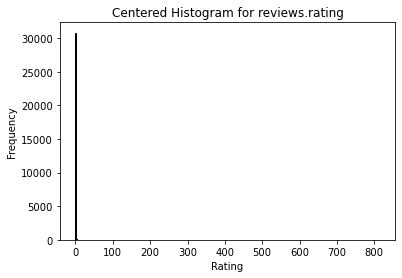

In [6]:
data = amazon_reviews['reviews.numHelpful']

num_bins = 16  
bin_width = 1

bin_boundaries = np.arange(min(data) - bin_width/2, max(data) + bin_width/2 + 1, bin_width)
bin_centers = bin_boundaries[:-1] + bin_width / 2

plt.hist(data, bins=bin_boundaries, edgecolor='black', rwidth = 0.8)

plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Centered Histogram for reviews.rating')

plt.show()

In [7]:
def random_select(df, n, rating, column): #choose the database and the number of samples with the indicated rating (specify the 
                                            # name of the column)
    rating_df = df[df[column] == rating]
    dff = rating_df.sample(n=n, random_state=42) 

    return dff

df3 = random_select(amazon_reviews, 5000, 0, 'reviews.numHelpful')

In [8]:
df3.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,0.0,5000.0,5000.000000,0.0,0.0
mean,NaN,0.0,4.615800,NaN,NaN
std,NaN,0.0,0.670731,NaN,NaN
min,NaN,0.0,1.000000,NaN,NaN
25%,NaN,0.0,4.000000,NaN,NaN
50%,NaN,0.0,5.000000,NaN,NaN
75%,NaN,0.0,5.000000,NaN,NaN
max,NaN,0.0,5.000000,NaN,NaN


In [9]:
df12 = amazon_reviews[amazon_reviews['reviews.numHelpful'] != 0]

In [10]:
df12.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,3311.000000,3807.000000,0.0,0.0
mean,111372787.0,6.496829,4.382191,NaN,NaN
std,NaN,41.985603,1.029889,NaN,NaN
min,111372787.0,1.000000,1.000000,NaN,NaN
25%,111372787.0,1.000000,4.000000,NaN,NaN
50%,111372787.0,1.000000,5.000000,NaN,NaN
75%,111372787.0,2.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


Now, we observe that the columns we will work with are id (or name, they are correlated) and reviews.text. We will create a new database with these two and add a column based on the reviews.numHelpful :

- 0 : numHelpful = 0
- 1 : numHelpful != 0

### Now let us create the final database we will actually work with:

In [11]:
amazon = pd.concat([df12, df3], ignore_index=True)
amazon.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,8311.000000,8807.000000,0.0,0.0
mean,111372787.0,2.588257,4.514818,NaN,NaN
std,NaN,26.688277,0.852766,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,1.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


## We now need to create the label:

In [12]:

def label(r):
    if r > 0:
        return 1
    return 0

amazon['label'] = amazon['reviews.numHelpful'].apply(label)


# This will be the database for our Sentiment Analysis:

In [15]:
amazon = amazon[['id', 'reviews.text', 'reviews.numHelpful', 'label']]
amazon.describe()
amazon.tail()

,id,reviews.text,reviews.numHelpful,label
8835,AV1YnRtnglJLPUi8IJmV,Such a great reading tablet it has a back ligh...,0.0,0
8836,AVqkIhwDv8e3D1O-lebb,Very good buy. I am enjoying my new tablet. Gr...,0.0,0
8837,AVpfl8cLLJeJML43AE3S,Love being able to walk in from work and ask A...,0.0,0
8838,AVpjEN4jLJeJML43rpUe,"Got this tablet for my 3 year old daughter, an...",0.0,0
8839,AVpfl8cLLJeJML43AE3S,Lots of fun and educational- you can learn a l...,0.0,0


## Let us observe how our database behaves:

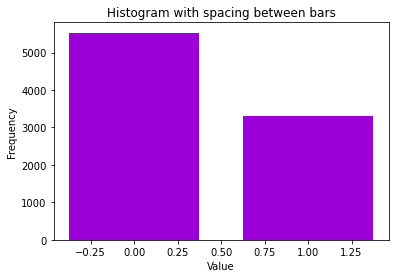

In [16]:
data = amazon['label']
min_bin = - 0.5
max_bin = 1.5
bins = np.arange(min_bin, max_bin + 1, 1)  

counts, edges = np.histogram(data, bins=bins)

bar_width = 0.75

for left, height in zip(edges[:-1], counts):
    plt.bar(left + 0.5 * (1 - bar_width), height, width=bar_width, align='edge', color='#9b00d9')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with spacing between bars')
plt.show()

## Now, let us part our database in the two categories we have defined

In [30]:
#good = amazon[amazon['label'] == 2]
helpful = amazon[amazon['label'] == 1]
nonhelpful = amazon[amazon['label'] == 0]

### In order to better visualise these, we can plot some wordclouds

In [18]:
!pip install wordcloud
from wordcloud import WordCloud

In [21]:
'''
goods = helpful['reviews.text'].tolist()
goods = [str(x) for x in goods]
goods_sentence = " ".join(goods)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(goods_sentence))
'''

'\ngoods = helpful[\'reviews.text\'].tolist()\ngoods = [str(x) for x in goods]\ngoods_sentence = " ".join(goods)\nplt.figure(figsize=(20,20))\nplt.imshow(WordCloud().generate(goods_sentence))\n'

In [22]:
'''
neutrals = neutral['reviews.text'].tolist()
neutrals = [str(x) for x in neutrals]
neutrals_sentence = " ".join(neutrals)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(neutrals_sentence))
'''

'\nneutrals = neutral[\'reviews.text\'].tolist()\nneutrals = [str(x) for x in neutrals]\nneutrals_sentence = " ".join(neutrals)\nplt.figure(figsize=(20,20))\nplt.imshow(WordCloud().generate(neutrals_sentence))\n'

In [67]:
'''
bads = bad['reviews.text'].tolist()
bads = [str(x) for x in bads]
bads_sentence = " ".join(bads)
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(bads_sentence))
'''

'\nbads = bad[\'reviews.text\'].tolist()\nbads = [str(x) for x in bads]\nbads_sentence = " ".join(bads)\nplt.figure(figsize=(20,20))\nplt.imshow(WordCloud().generate(bads_sentence))\n'

# Now it's time for some data cleaning!

## Punctuation

In [23]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
# For good
g = []
goods = helpful['reviews.text'].tolist()
goods = [str(x) for x in goods]
for s in goods:
    sentence = [c for c in s if c not in string.punctuation]
    s = ''.join(sentence)
    g.append(s)
goods = g
goods

['Bought this for my 87 year old grandmother who wanted to be able to play games and read books from the library My aunt lives with her and can help her use it so its perfect for that type of user After playing with It I would consider it for just about anyone other than a hardcore user that wants the latest and greatest tech if you are tech saavy you can do more with these Fire tablets than advertised',
 'Bought this to replace noname budget tablet for my daughter She loves this as it is much faster and has a better display than her old tablet This is a wonderful value as it is faster has a better display and sound is a name brand and cost about the same  whats not to love about this product',
 'She loves this tablet It works well unlike her bargain tablet which she tried to use previously and cost about the same She likes the sound of it also She enjoys the free games she downloaded and navigates the wev easily with it',
 'i Bought this around black friday for 60 hoping it would be a

In [31]:
# For bad
bads = nonhelpful['reviews.text'].tolist()
bads = [str(x) for x in bads]
b = []
for s in bads:
    sentence = [c for c in s if c not in string.punctuation]
    s = ''.join(sentence)
    b.append(s)
bads = b
bads

['The Kindle is my first eink reader I own an iPad an iPhone and have owned a Windowsbased phone in the past that I used as an ereaderMy overall impression of the device is goodThe goodId honestly rather read linear read from page one to the end one page at a time fiction from it than a book because I cant always get comfortable with a book Hardcovers are sometimes a bit heavy and paperbacks dont always lie open easily The Kindle is incredibly light and thin I can hold it in one hand easily The page turn buttons are conveniently located Pageturns arent instant but theyre probably quicker than turning a physical page in a printed book there are just a lot more pageturns unless you choose a small font The contrast is better than other ereaders Ive seen There is zero eye strain in good light My eyesight isnt the greatest and I like being able to increase the font size and read without glasses I love being able to browse the Kindle store and read samples before deciding to purchase The exp

## Stopwords

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
# For good
g = []
for s in goods:
    sentence = [word for word in s.split() if word not in stopwords.words('english')]
    s = ' '.join(sentence)
    g.append(s)

goods = g
goods

['Bought 87 year old grandmother wanted able play games read books library My aunt lives help use perfect type user After playing It I would consider anyone hardcore user wants latest greatest tech tech saavy Fire tablets advertised',
 'Bought replace noname budget tablet daughter She loves much faster better display old tablet This wonderful value faster better display sound name brand cost whats love product',
 'She loves tablet It works well unlike bargain tablet tried use previously cost She likes sound also She enjoys free games downloaded navigates wev easily',
 'Bought around black friday 60 hoping would awesome failed hard tried multiple different micro SD cards none recognized YES formated every format could think Fat32 NTFS Fat Xfat even tried tablet didnt work make matters worse half apps wanted use werent app store came find isnt linked normal google play store tablet app store missing many common apps main reason bought play clash clans cant wasnt app store tried also use 

In [35]:
# For bad

b = []
for s in bads:
    sentence = [word for word in s.split() if word not in stopwords.words('english')]
    s = ' '.join(sentence)
    b.append(s)

bads = b
bads

['The Kindle first eink reader I iPad iPhone owned Windowsbased phone past I used ereaderMy overall impression device goodThe goodId honestly rather read linear read page one end one page time fiction book I cant always get comfortable book Hardcovers sometimes bit heavy paperbacks dont always lie open easily The Kindle incredibly light thin I hold one hand easily The page turn buttons conveniently located Pageturns arent instant theyre probably quicker turning physical page printed book lot pageturns unless choose small font The contrast better ereaders Ive seen There zero eye strain good light My eyesight isnt greatest I like able increase font size read without glasses I love able browse Kindle store read samples deciding purchase The experimental browser surprisingly usable isnt great It useful browsing wikipedia blogs The biggest drawback browser awkward pointer navigation using 5way pad It syncs furthest read page internet pick left using iPhone iPadThe sosoThe kindle store could

## Now, let us put it all together into a pipeline:

In [36]:
def data_cleaning(text):

    Test_punc_removed = [char for char in text if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    
    return Test_punc_removed_join_clean    

# Now we can perform tokenization!

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# amazon_clean = amazon['reviews.text'].apply(data_cleaning)
amazon['reviews.text'] = amazon['reviews.text'].fillna('')

In [79]:
# print(amazon_clean[11])

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
vectorizer = CountVectorizer(analyzer = data_cleaning, dtype = np.uint8)

In [41]:
amazon_countvectorizer = vectorizer.fit_transform(amazon['reviews.text'])

In [42]:
print(amazon_countvectorizer.toarray())  

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [43]:
amazon_countvectorizer.shape

(8840, 12375)

In [44]:
X = pd.DataFrame(amazon_countvectorizer.toarray())

In [45]:
X

,0,1,2,3,4,5,6,7,8,9,...,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# We will now use Naive Bayes in order to continue:

In [46]:
y = amazon['label']

In [47]:
X.shape

(8840, 12375)

In [48]:
y.shape

(8840,)

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07)

In [98]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

In [99]:
from sklearn.metrics import classification_report, confusion_matrix

<AxesSubplot:>

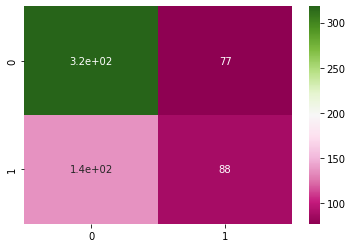

In [100]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True, cmap="PiYG")

In [101]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       395
           1       0.53      0.39      0.45       224

    accuracy                           0.66       619
   macro avg       0.62      0.60      0.60       619
weighted avg       0.64      0.66      0.64       619



# More Methods:

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.69      0.81      0.74       830
           1       0.55      0.39      0.45       496

    accuracy                           0.65      1326
   macro avg       0.62      0.60      0.60      1326
weighted avg       0.64      0.65      0.64      1326



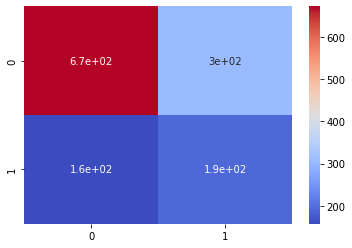

In [54]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True, cmap="coolwarm")

print(classification_report(y_test, y_pred))

# At this point we can observe that the accuracy is worryingly low, how the model works best on extremes, but has really big troubles in detecting the neutral labels. We will therefore train on the whole database for the sake of it and look for a better accuracy - at least for the extreme labels.

In [55]:
amazon_reviews = pd.read_csv("Amazon Reviews 1.csv")
amazon_reviews.dropna(subset = ["reviews.text"])
amazon_reviews.dropna(subset = ["reviews.title"])
amazon_reviews.dropna(subset = ["reviews.rating"])

C:\Users\andre\AppData\Local\Temp\ipykernel_4404\2946610846.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  amazon_reviews = pd.read_csv("Amazon Reviews 1.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34655,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-09-18T00:00:00Z,NaN,2015-08-29T00:00:00Z,...,NaN,NaN,NaN,3.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...,NaN,NaN,Kris
34656,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-11-21T00:00:00Z,NaN,2015-09-02T00:00:00Z,...,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Amazon should include this charger with the Ki...,Should be included,NaN,NaN,Jonathan Stewart
34657,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Services, Inc",2012-10-19T00:00:00Z,NaN,2015-09-04T00:00:00Z,...,NaN,NaN,NaN,1.0,http://www.amazon.com/Amazon-PowerFast-Adapter...,Love my Kindle Fire but I am really disappoint...,Disappointing Charger,NaN,NaN,J Lawson
34658,AVpfiBlyLJeJML43-4Tp,NaN,B006GWO5WK,Amazon,"Computers/Tablets & Networking,Tablet & eBook ...",newamazonkindlefirehd9wpowerfastadaptercharger...,"Amazon Digital Ser

In [56]:
amazon = amazon_reviews[['id', 'reviews.text', 'reviews.rating']]
amazon.describe()

,reviews.rating
count,34627.000000
mean,4.584573
std,0.735653
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## In case we have NaN entries for the reviews' text, we just "clean" them:

In [ ]:
amazon['reviews.text'] = amazon['reviews.text'].fillna('')

In [ ]:
def label(r):
    if r >= 4.0:
        return 1
    return 0


amazon['label'] = amazon['reviews.rating'].apply(label)
amazon.describe()

In [ ]:
data = amazon['label']
min_bin = - 0.5
max_bin = 2.5
bins = np.arange(min_bin, max_bin + 1, 1)  

counts, edges = np.histogram(data, bins=bins)

bar_width = 0.75

for left, height in zip(edges[:-1], counts):
    plt.bar(left + 0.5 * (1 - bar_width), height, width=bar_width, align='edge', color='#9b00d9')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with spacing between bars')
plt.show()

In [ ]:
vectorizer = CountVectorizer(analyzer = data_cleaning, dtype = np.uint8)
amazon_countvectorizer = vectorizer.fit_transform(amazon['reviews.text'])
print(amazon_countvectorizer.toarray())  

In [ ]:
X = pd.DataFrame(amazon_countvectorizer.toarray())
X

In [ ]:
y = amazon['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True, cmap="PiYG")

In [ ]:
print(classification_report(y_test, y_predict_test))

## For more methods:

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot = True, cmap="coolwarm")

print(classification_report(y_test, y_pred))